In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import sparse

from pynufft import NUFFT_cpu

import pylops

# Description of the matrix approach 

For **real** data we solve the system

$\left[ \tilde{f}^T \tilde{f} + R^T R \right] x = \tilde{f}^T y$

where $\tilde{f} = D f$ is a real matrix of shape ($n_p$, $n_s$). $f$ is a real matrix of shape ($n_p$, $n_s$), $D$ is the convolution which is a real matrix of shape ($n_p$, $n_p$) and $H = R^T R$ is the regularization matrix.

$------------------------------------$

For **complex** data we instead solve the system

$\left[ \tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

where $\tilde{f} = D f$ is a compex matrix of shape ($n_v$, $n_s$). $f$ is a real matrix of shape ($n_p$, $n_s$) and $D$ is the non-uniform fast fourier transform (NUFFT) which is a complex matrix of shape ($n_v$, $n_p$).

***Note:*** Since we require the solution to be real the following inequality holds

$ \left( \tilde{f_{\Re}}^T \tilde{f_{\Re}} \right)^{-1} \tilde{f_{\Re}}^T y_{\Re} \ne \left( \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right)^{-1} \tilde{f_{\Im}}^T y_{\Im}$

In our matrix approach (for complex data), regularization is applied after we sum the real and imag components

$\left[ \left(\tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right) + R^T R \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

$------------------------------------$

To summarize, in our matrix approach, the solution $x$ is always real as the matrix inversion is performed with "real" matrices, which have been constructed from the sum of the real and imag compponents of a originaly complex matrix.

| Object | Dimension | type | Description |
|------|------|------|------|
|   $n_v$  | - | - | # of visibilities |
|   $n_p$  | - | - | # of image-plane pixels |
|   $n_s$  | - | - | # of source-plane pixels |
|------|------|------|
|   $f$  | $(n_p, n_s)$ | real | mapping matrix |
|   $D$  | $(n_v, n_p)$ | complex | non-uniform fast fourier transform (NUFFT) |
|   $\tilde{f}$  | $(n_v, n_s)$ | complex | NUFFT'd mapping matrix |

# Pylops 

In [84]:
# def NormalEquationsInversion_with_real_and_imag_Ops(
#     Op_real, 
#     Op_imag, 
#     data_real, 
#     data_imag,
#     HOp=None,
#     returninfo=False, 
#     **kwargs_cg
# ):

#     OpH_real = Op_real.H
#     OpH_imag = Op_imag.H

#     Op_normal_real = OpH_real * Op_real
#     Op_normal_imag = OpH_imag * Op_imag
#     Op_normal = (Op_normal_real + Op_normal_imag)
    
#     if HOp is not None:
#         Op_normal += HOp

#     y_normal_real = OpH_real * data_real
#     y_normal_imag = OpH_imag * data_imag
#     y_normal = y_normal_real + y_normal_imag

#     xinv, istop = sparse.linalg.cg(Op_normal, y_normal, **kwargs_cg)

#     if returninfo:
#         return xinv, istop
#     else:
#         return xinv
    
    
def NormalEquationsInversion(
    Op, 
    data, 
    HOp=None,
    returninfo=False, 
    **kwargs_cg
):

    OpH = Op.H

    if WOp is not None:
        Op_normal = OpH * WOp * Op
    else:
        Op_normal = OpH * Op
    
    if HOp is not None:
        Op_normal += HOp

    if WOp is not None:
        y_normal = OpH * WOp * data
    else:
        y_normal = OpH * data

    xinv, istop = sparse.linalg.cg(Op_normal, y_normal, **kwargs_cg)

    if returninfo:
        return xinv, istop
    else:
        return xinv

***The non-uniform fast fourier transform operator***

In [3]:
class D_Op(NUFFT_cpu, pylops.LinearOperator):
    def __init__(self, uv, shape_2d, reshaping_x=True):
        super(D_Op, self).__init__()

        self.u, self.v = uv.T

        om = np.array([self.u, self.v]).T
        
        self.shape_2d = shape_2d

        self.plan(
            om=om,
            Nd=self.shape_2d,
            Kd=(
                int(2 * self.shape_2d[0]),
                int(2 * self.shape_2d[1])
            ),
            Jd=(6, 6),
        )

        n_p = int(self.shape_2d[0] * self.shape_2d[1])

        self.shape = (uv.shape[0], n_p)
        self.dtype = "complex128"
        self.explicit = False
        
        self.reshaping_x = reshaping_x
        
    def reshape_x(self, x):
        # NOTE: The array "x" is real as it represents an image of shape (n * n; i.e. flattened). This function
        # reshaped the array to (n, n).
        return x.reshape(self.shape_2d)

    def forward_lop(self, x):
        # NOTE: Takes an "image" (array) of shape (n, n) and performs the non-uniform 
        # fast fourier transform resulting in a complex matrix of length n_v.
        
        # NOTE: The array "x" that is passed was flattened so we reshape it to the shape (n, n)
        # that NUFFT requires.
        if self.reshaping_x:
            x = self.reshape_x(x=x)
            
        y = self.k2y(self.xx2k(self.x2xx(x)))

        return y

    def adjoint_lop(self, y):

        x = self.xx2x(self.k2xx(self.y2k(y)))

        return x

    def _matvec(self, x):
        return self.forward_lop(x)

    def _rmatvec(self, x):
        return self.adjoint_lop(x)
    
    
class D_Op_real(D_Op):

    def _forward_lop(self, x):
        return np.real(self.forward_lop(x=x))

    def _adjoint_lop(self, y):
        return np.real(self.adjoint_lop(y=y))

    def _matvec(self, x):
        return self._forward_lop(x)

    def _rmatvec(self, x):
        return self._adjoint_lop(x)

class D_Op_imag(D_Op):

    def _forward_lop(self, x):
        return np.imag(self.forward_lop(x=x))

    def _adjoint_lop(self, y):
        return np.imag(self.adjoint_lop(y=y))

    def _matvec(self, x):
        return self._forward_lop(x)

    def _rmatvec(self, x):
        return self._adjoint_lop(x)

**The regularization operator**

In [4]:
class H_Op(pylops.LinearOperator):
    def __init__(self, h, dtype="float64"):

        self.h = h
        self.pixels = h.shape[0]
        self.dims = self.pixels
        self.shape = (self.pixels, self.pixels)
        self.dtype = dtype
        self.explicit = False

    def _matvec(self, x):
        return np.dot(self.h, x)

    def _rmatvec(self, x):
        return np.dot(self.h.T, x)

# Tools

## general

In [5]:
def a_complex_from_a_real_and_a_imag(
    a_real, 
    a_imag
):
    # NOTE: Convert a numpy array of shape (n, 2) to a complex array of shape (n, )

    a_complex = np.stack(
        arrays=(a_real, a_imag), axis=-1
    )

    a_complex = np.apply_along_axis(
        lambda args: [complex(*args)], len(a_complex.shape) - 1, a_complex
    ).astype("complex128")

    return np.squeeze(a_complex)

In [6]:
# NOTE: Make a "random" sparse matrix (with 0's & 1's)
def random_sparse_matrix(n_p, n_s):

    def nonzero_to_ones(a):

        a[np.where(a > 0.0)] = 1.0

        return a

    f_obj = sparse.random(
        m=n_p, n=n_s
    )

    return nonzero_to_ones(
        a=f_obj.A
    )

In [22]:
def reshape(a, shape_2d):

    return a.reshape(shape_2d)

## visualization

In [8]:
def plot_1_to_1_from_x(x):
    
    x_min = np.min(x)
    x_max = np.max(x)
    
    plt.plot(
        np.linspace(x_min, x_max, 10),
        np.linspace(x_min, x_max, 10),
        linestyle="--",
        color="black"
    )

In [9]:
def add_colorbar_to_axes(figure, im, axes):

    cax = make_axes_locatable(
        axes
    ).append_axes('right', size='5%', pad=0.05)

    figure.colorbar(
        im,
        cax=cax,
        orientation='vertical'
    )

In [10]:
def visualize_f(f, shape_2d, nrows, ncols, figsize):

    if nrows * ncols < f.shape[-1]:
        raise ValueError("")
        
    figure, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=figsize
    )

    k = 0
    for i in range(nrows):
        for j in range(ncols):

            f_k = f[:, k]

            f_k_reshaped = reshape(
                a=f_k, shape_2d=shape_2d
            )

            axes[i, j].imshow(f_k_reshaped)

            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            k += 1
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

# Examples

## Example 1

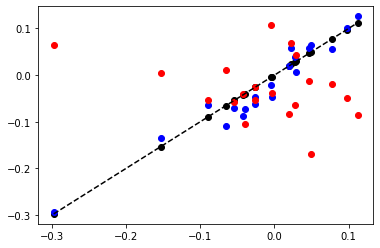

In [11]:
N_vis = 100
N_grid = 400
N_src = 20

#f_real = np.random.normal(0.0, 1.0, size=(N_grid, N_src))
#f_imag = np.random.normal(0.0, 1.0, size=(N_grid, N_src))

f_tilde_real = np.random.normal(0.0, 1.0, size=(N_vis, N_src))
f_tilde_imag = np.random.normal(0.0, 1.0, size=(N_vis, N_src))

F_real = np.dot(f_tilde_real.T, f_tilde_real)
F_imag = np.dot(f_tilde_imag.T, f_tilde_imag)

d_real = np.random.normal(0.0, 1.0, size=(N_vis, ))
d_imag = np.random.normal(0.0, 1.0, size=(N_vis, ))

D_real = np.dot(f_tilde_real.T, d_real)
D_imag = np.dot(f_tilde_imag.T, d_imag)

# NOTE: This is the linear system Ax = y we are solving in our matrix approach.
x = np.linalg.solve(
    F_real + F_imag, 
    D_real + D_imag
)

# NOTE: For real-world applications D_real != D_imag & F_real != F_imag, therefore there is not
# a single "real" vector x that satisfies both systems (this is in respose to https://github.com/PyLops/pylops_notebooks/blob/master/developement/ComplexMatmul.ipynb). 
x_real = np.linalg.solve(F_real, D_real)
x_imag = np.linalg.solve(F_imag, D_imag)

# ------------------ 
# NOTE: Method 1
# ------------------ 

f_tilde_real_lops = pylops.MatrixMult(f_tilde_real, dtype='float64')
f_tilde_imag_lops = pylops.MatrixMult(f_tilde_imag, dtype='float64')

x_lops_method_1 = NormalEquationsInversion_with_real_and_imag_Ops(
    Op_real=f_tilde_real_lops,
    Op_imag=f_tilde_imag_lops,
    data_real=d_real,
    data_imag=d_imag
)

# ------------------ 
# NOTE: Method 2
# ------------------

f_tilde_complex = a_complex_from_a_real_and_a_imag(
    a_real=f_tilde_real, 
    a_imag=f_tilde_imag
)
f_tilde_complex_lops = pylops.MatrixMult(
    f_tilde_complex, dtype="complex128"
)

d_complex = a_complex_from_a_real_and_a_imag(
    a_real=d_real, a_imag=d_imag
)

x_lops_method_2 = NormalEquationsInversion(
    Op=f_tilde_complex_lops,
    data=d_complex
)

# ------------------ 
# visualization
# ------------------ 

plt.figure()
plt.plot(x, x_lops_method_1, linestyle="None", marker="o", color="black")
plt.plot(x, x_lops_method_2.real, linestyle="None", marker="o", color="b")
plt.plot(x, x_lops_method_2.imag, linestyle="None", marker="o", color="r")
#plt.plot(x_real, x_lops_method_2.real, linestyle="None", marker="s", color="b")
#plt.plot(x_imag, x_lops_method_2.imag, linestyle="None", marker="s", color="r")
x_min = np.min(x)
x_max = np.max(x)
plt.plot(
    np.linspace(x_min, x_max, 10),
    np.linspace(x_min, x_max, 10),
    linestyle="--",
    color="black"
)
plt.show()

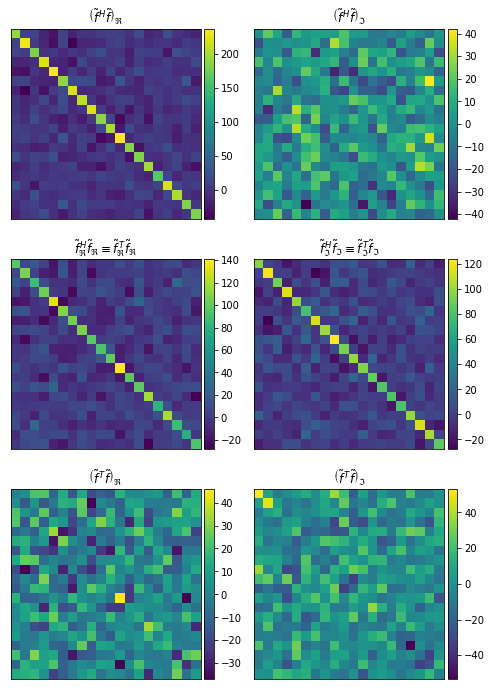

In [35]:
prod_f_tilde_complex_H = np.dot(
    f_tilde_complex.conj().T, 
    f_tilde_complex
)
prod_f_tilde_complex_T = np.dot(
    f_tilde_complex.T, 
    f_tilde_complex
)

figure, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(8, 12)
)

im00 = axes[0, 0].imshow(prod_f_tilde_complex_H.real)
im01 = axes[0, 1].imshow(prod_f_tilde_complex_H.imag)
im10 = axes[1, 0].imshow(np.dot(f_tilde_real.conj().T, f_tilde_real))
im11 = axes[1, 1].imshow(np.dot(f_tilde_imag.conj().T, f_tilde_imag))
im20 = axes[2, 0].imshow(prod_f_tilde_complex_T.real)
im21 = axes[2, 1].imshow(prod_f_tilde_complex_T.imag)

add_colorbar_to_axes(figure=figure, im=im00, axes=axes[0, 0])
add_colorbar_to_axes(figure=figure, im=im01, axes=axes[0, 1])
add_colorbar_to_axes(figure=figure, im=im10, axes=axes[1, 0])
add_colorbar_to_axes(figure=figure, im=im11, axes=axes[1, 1])
add_colorbar_to_axes(figure=figure, im=im20, axes=axes[2, 0])
add_colorbar_to_axes(figure=figure, im=im21, axes=axes[2, 1])

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

axes[0, 0].title.set_text(r"$\left( \tilde{f}^{\, H} \tilde{f} \right)_{\Re}$")
axes[0, 1].title.set_text(r"$\left( \tilde{f}^{\, H} \tilde{f} \right)_{\Im}$")
axes[1, 0].title.set_text(r"$\tilde{f}_{\Re}^{\, H} \tilde{f}_{\Re} \equiv \tilde{f}_{\Re}^{\, T} \tilde{f}_{\Re}$")
axes[1, 1].title.set_text(r"$\tilde{f}_{\Im}^{\, H} \tilde{f}_{\Im} \equiv \tilde{f}_{\Im}^{\, T} \tilde{f}_{\Im}$")
axes[2, 0].title.set_text(r"$\left( \tilde{f}^{\, T} \tilde{f} \right)_{\Re}$")
axes[2, 1].title.set_text(r"$\left( \tilde{f}^{\, T} \tilde{f} \right)_{\Im}$")

plt.show()

## Example 2

In [22]:
regularization = False

**NOTE:** If the inversion gives an error (signular matrix) rerun the example from this step.

In [23]:
n_v = 100 # NOTE: n_v is the # of visibilities

# NOTE: Non-uniform points in the uv-space
u = np.random.uniform(-1.0, 1.0, n_v)
v = np.random.uniform(-1.0, 1.0, n_v)

uv = np.stack(
    arrays=(u, v), axis=-1
)

Define the # of source-pixels, $n_s$, and the # image-pixels, $n_p$.

In [24]:
# NOTE: n_s is the # of source-plane pixels
n_s = 20

shape_2d = (20, 20)

# NOTE: n_p is the # of image-plane pixels
n_p = int(shape_2d[0] * shape_2d[1]) 

In [25]:
f = random_sparse_matrix(
    n_p=n_p, n_s=n_s
)

***NOTE:*** For real-world application each of the images below represents where in the image plane each source-pixel is mapped.

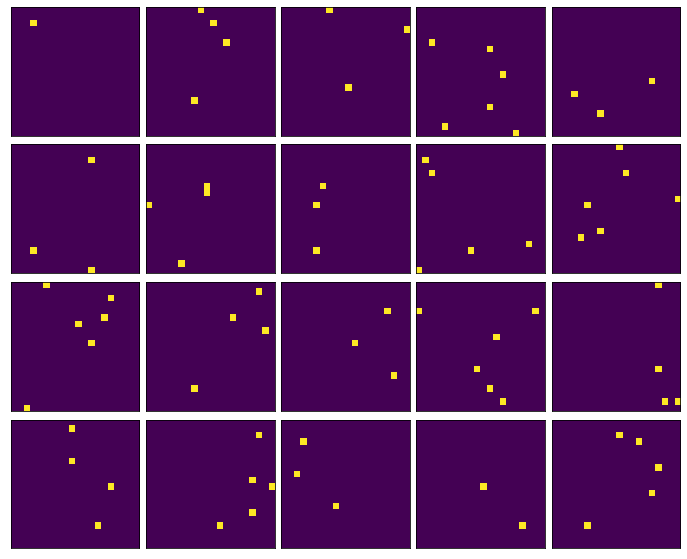

In [26]:
visualize_f(
    f=f, shape_2d=shape_2d, nrows=4, ncols=5, figsize=(12, 10)
)

***Initialize the non-uniform fast fourier transform operator.***

In [27]:
Dop = D_Op(uv=uv, shape_2d=shape_2d)

**Compute the $\tilde{f}$ matrix**

**NOTE:** In the **"Matrix Formalism"** we need to explicitly construct the matrix $\tilde{f}$ which is a very expensive operation. For real-world problems $n_v$ is of the order of $\sim 10^{9} - 10^{12}$ limiting us not only in terms of run times but also in terms of memory usage. **The goal with the "Pylops Formalism" is to express $\tilde{f}$ as a linear Operator utilizing the fact that $f$ is sparse.**

In [28]:
# NOTE: Construct the $\tilde{f}$ matrix
f_tilde = np.zeros(
    shape=(n_v, n_s), dtype="complex"
)
for i in range(f.shape[-1]):
    f_tilde[:, i] = Dop.forward_lop(x=f[:, i])

f_tilde_real = f_tilde.real
f_tilde_imag = f_tilde.imag

**NOTE:**

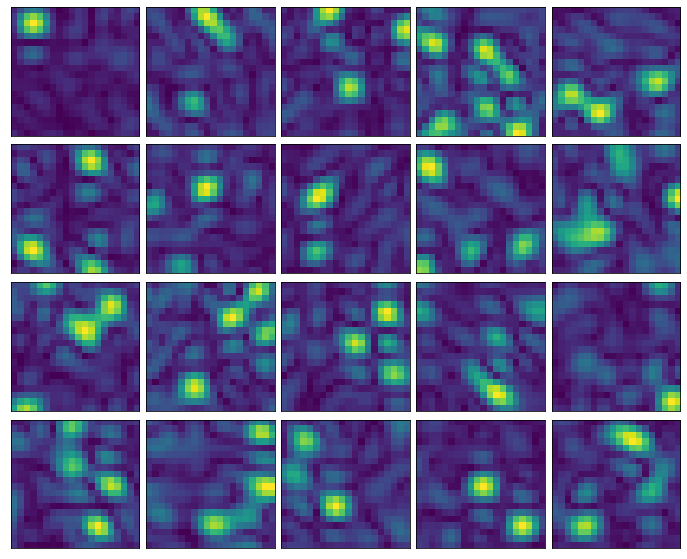

In [29]:
f_tilde_tilde = np.zeros(shape=f.shape)
for i in range(f.shape[-1]):
    f_tilde_tilde[:, i] = np.ndarray.flatten(
        abs(Dop.adjoint_lop(y=f_tilde[:, i]))
    )
#     f_tilde_tilde[:, i] = np.ndarray.flatten(
#         Dop.adjoint_lop(y=f_tilde_i).real
#     )
#     f_tilde_tilde[:, i] = np.ndarray.flatten(
#         Dop.adjoint_lop(y=f_tilde_i).imag
#     )
    
visualize_f(
    f=f_tilde_tilde, shape_2d=shape_2d, nrows=4, ncols=5, figsize=(12, 10)
)

**Initialize the**

In [30]:
H = np.random.normal(0.0, 1.0, size=(n_s, n_s))

# NOTE: ...
HOp = H_Op(h=H)

### Calculate

In [31]:
y_real = np.random.normal(0.0, 1.0, size=(n_v, ))
y_imag = np.random.normal(0.0, 1.0, size=(n_v, ))

**Matrix Formalism:**

In [32]:
F_real = np.dot(f_tilde_real.T, f_tilde_real)
F_imag = np.dot(f_tilde_imag.T, f_tilde_imag)

D_real = np.dot(f_tilde_real.T, y_real)
D_imag = np.dot(f_tilde_imag.T, y_imag)

if regularization:
    x = np.linalg.solve(
        (F_real + F_imag) + H,
        D_real + D_imag
    )
else:
    x = np.linalg.solve(
        F_real + F_imag,
        D_real + D_imag
    )

# NOTE: 
if regularization:
    x_real = np.linalg.solve(F_real + H, D_real)
    x_imag = np.linalg.solve(F_imag + H, D_imag)
else:
    x_real = np.linalg.solve(F_real, D_real)
    x_imag = np.linalg.solve(F_imag, D_imag)

**Pylops Formalism (method 1):**

In [33]:
# NOTE: This is the current version of our Pylops formalism (i.e. method 1). It gives us a 
# complex solution which is not what we want.
f_lops = pylops.MatrixMult(
    sparse.bsr_matrix(f), dtype='float64'
)

Op = Dop * f_lops

data = a_complex_from_a_real_and_a_imag(
    a_real=y_real, a_imag=y_imag
)

x_lops = NormalEquationsInversion(
    Op=Op, 
    data=data,
    HOp=HOp if regularization else None
)

**Pylops Formalism (method 2):**

In [34]:
# NOTE: This is a modified version of our Pylops formalism (i.e. method 2), which is 
# still not giving us the same answer as the Matrix Formalism.
Dop_real = D_Op_real(uv=uv, shape_2d=shape_2d)
Dop_imag = D_Op_imag(uv=uv, shape_2d=shape_2d)

f_lops = pylops.MatrixMult(
    sparse.bsr_matrix(f), dtype='float64'
)

Op_real = Dop_real * f_lops
Op_imag = Dop_imag * f_lops

x_lops_with_real_and_imag_Ops = NormalEquationsInversion_with_real_and_imag_Ops(
    Op_real=Op_real, 
    Op_imag=Op_imag, 
    data_real=y_real, 
    data_imag=y_imag, 
    HOp=HOp if regularization else None
)

# NOTE: Now the solution is "real" or rather the "imag" component is zero.
print(x_lops_with_real_and_imag_Ops)

x_lops_with_real_and_imag_Ops = x_lops_with_real_and_imag_Ops.real

[ 0.97546486+0.j  0.50863014+0.j -0.25884016+0.j  0.79304183+0.j
  0.10098012+0.j  0.24280916+0.j  0.00964472+0.j -0.11555856+0.j
 -0.14070797+0.j  0.64423698+0.j -0.69919319+0.j -0.08850856+0.j
  0.49400151+0.j -0.44729713+0.j -0.30598498+0.j  0.18770602+0.j
  0.10409419+0.j -0.49201734+0.j  0.29444442+0.j -0.42535141+0.j]


**NOTE: Does this gives us an indication of what the problem might be?**

In [35]:

b = Op * x
x_inv = Op.H * b

b_real = Op_real * x
b_imag = Op_imag * x

x_inv_real = Op_real.H * b_real
x_inv_imag = Op_imag.H * b_imag

Op_from_real_and_imag_Ops = Op_real + Op_imag
b_from_real_and_imag_Ops = Op_from_real_and_imag_Ops * x
x_inv_from_real_and_imag_Ops = Op_from_real_and_imag_Ops.H * b_from_real_and_imag_Ops

print(
    "x = ", x, "\n"
    "x_inv = ", x_inv, "\n"
    "x_inv_real = ", x_inv_real, "\n",
    "x_inv_imag = ", x_inv_imag, "\n",
    #x_inv_from_real_and_imag_Ops
)

x =  [ 0.0618604   0.07009705  0.0100867   0.04480762  0.03080384  0.10051977
 -0.03020426 -0.02815905 -0.01198409  0.01013602 -0.00561984  0.05031184
  0.08351044 -0.09158109 -0.04982308  0.05835871 -0.0001775   0.02374979
 -0.02484245 -0.07276106] 
x_inv =  [ 0.00502926+0.00163976j  0.02644841-0.00127325j  0.00358409-0.0002259j
 -0.00089043-0.00075483j  0.00469036+0.00043315j  0.01288265-0.00221385j
 -0.00585826+0.00105728j -0.0030393 +0.00044161j  0.00581279+0.00125958j
  0.02058532-0.00260268j  0.00754277+0.00228437j  0.01254239-0.00279966j
  0.0047618 +0.00128438j -0.01338407-0.00075259j -0.00939107-0.00095897j
  0.00229343+0.00435241j  0.00131467+0.00219035j  0.00251365+0.00076064j
 -0.00039097-0.00012457j  0.01603758+0.00035851j] 
x_inv_real =  [ 5.38945350e-04  1.80245144e-02  5.65367403e-03  1.91430651e-03
  4.72373694e-03  1.22471813e-02 -3.10532866e-03  4.08270011e-05
  2.88945109e-03  1.18741572e-02  3.97255630e-03  1.18475408e-02
  2.20105280e-03 -2.75575770e-03 -3.6921527

### visualization

**Matrix Formalism:**

Let's compare the $\textbf{"true"}$ solution we get from solving the system

$\left[ \tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

with the solutions we get from each of the following systems

$\left( \tilde{f_{\Re}}^T \tilde{f_{\Re}} \right) x_{\Re} = \tilde{f_{\Re}}^T y_{\Re}$

$\left( \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right) x_{\Im} = \tilde{f_{\Im}}^T y_{\Im}$

This is to demonstrate that

$\left( \tilde{f_{\Re}}^T \tilde{f_{\Re}} \right)^{-1} \tilde{f_{\Re}}^T y_{\Re} \ne \left( \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right)^{-1} \tilde{f_{\Im}}^T y_{\Im}$

which, however, we already showed in **Example 1**.

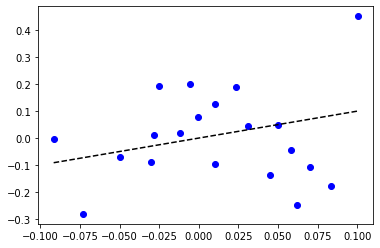

In [36]:
plt.plot(x, x_real, linestyle="None", marker="o", color="b")

plot_1_to_1_from_x(x=x)

plt.show()

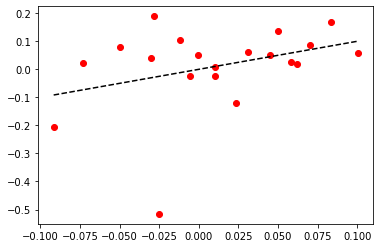

In [37]:
plt.plot(x, x_imag, linestyle="None", marker="o", color="r")

plot_1_to_1_from_x(x=x)

plt.show()

**Matrix vs Pylops Formalism:**

Let's compare the solutions we get from each of the following systems using the Matrix Formalism

$\left( \tilde{f_{\Re}}^T \tilde{f_{\Re}} \right) x_{\Re} = \tilde{f_{\Re}}^T y_{\Re}$

$\left( \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right) x_{\Im} = \tilde{f_{\Im}}^T y_{\Im}$

as well as the **"true"** solution we get from solving the system using again the Matrix Formalism

$\left[ \tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

with the **"complex"** solution we get using the **"method 1"** version of the Pylops formalism

$\left[ \tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

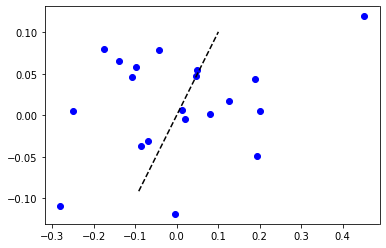

In [38]:
plt.plot(x_real, x_lops.real, linestyle="None", marker="o", color="b")

plot_1_to_1_from_x(x=x)

plt.show()

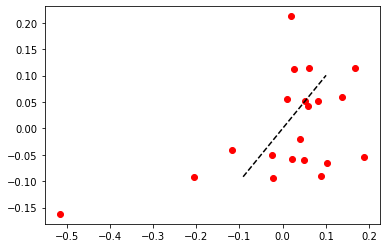

In [39]:
plt.plot(x_imag, x_lops.imag, linestyle="None", marker="o", color="r")

plot_1_to_1_from_x(x=x)

plt.show()

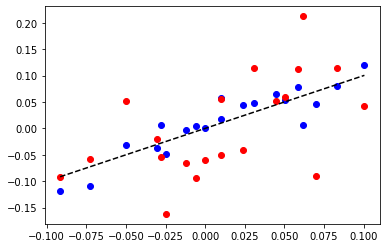

In [40]:
plt.figure()
plt.plot(x, x_lops.real, linestyle="None", marker="o", color="b")
plt.plot(x, x_lops.imag, linestyle="None", marker="o", color="r")

plot_1_to_1_from_x(x=x)

plt.show()

**NOTE:** The **"real"** and **"imag"** solutions from the **Pyloops Formalism** do not agree.

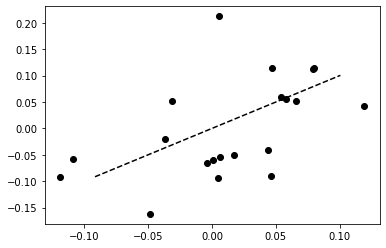

In [41]:
plt.plot(x_lops.real, x_lops.imag, linestyle="None", marker="o", color="black")

plot_1_to_1_from_x(x=x)

plt.show()

**Matrix vs Pylops Formalism:**

Let's compare the $\textbf{"true"}$ solution we get from solving the system using the **Matrix Formalism**

$\left[ \tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

with the **"real"** solution we get using the **"method 2"** version of the **Pylops Formalism**.

In [21]:
# plt.figure()
# plt.plot(x, x_lops_with_real_and_imag_Ops, linestyle="None", marker="s", color="g")

# plot_1_to_1_from_x(x=x)

# plt.show()

## Example 3

In [17]:
def x_for_MF(Dop, f, d_real, d_imag, WOp=None, HOp=None):

    f_tilde = np.zeros(
        shape=(Dop.shape[0], f.shape[-1]), dtype="complex"
    )
    for i in range(f_tilde.shape[-1]):
        f_tilde[:, i] = Dop.forward_lop(x=f[:, i])

    f_tilde_real = f_tilde.real
    f_tilde_imag = f_tilde.imag
    
    if WOp is not None:
        W = WOp.todense()
    else:
        W = np.diag(
            np.ones(shape=(Dop.shape[0]))
        )
        
    F_real = np.dot(np.dot(f_tilde_real.T, W), f_tilde_real)
    F_imag = np.dot(np.dot(f_tilde_imag.T, W), f_tilde_imag)

    D_real = np.dot(np.dot(f_tilde_real.T, W), d_real)
    D_imag = np.dot(np.dot(f_tilde_imag.T, W), d_imag)

    F = F_real + F_imag
    D = D_real + D_imag

    if regularization:
        if HOp is not None:
            H = HOp.todense()
        else:
            raise ValueError("...")

        x = np.linalg.solve(F + H, D)
    else:
        x = np.linalg.solve(F, D)

    return x


def x_for_PF(Dop, f, d_real, d_imag, WOp=None, HOp=None):

    f_lops = pylops.MatrixMult(
        sparse.bsr_matrix(f), dtype='float64'
    )

    Op = Dop * f_lops

    # NOTE:
    Op = Op.toreal(
        forw=False, adj=True
    )

    data = a_complex_from_a_real_and_a_imag(
        a_real=d_real, a_imag=d_imag
    )

    x_lops = NormalEquationsInversion(
        Op=Op,
        data=data,
        WOp=WOp,
        HOp=HOp
    )

    return x_lops

In [18]:
# NOTE: n_v is the # of visibilities
n_v = 100 

# NOTE: Non-uniform points in the uv-space
u = np.random.uniform(-1.0, 1.0, n_v)
v = np.random.uniform(-1.0, 1.0, n_v)
uv = np.stack(arrays=(u, v), axis=-1)

# NOTE: n_s is the # of source-plane pixels
n_s = 20

# NOTE: 
shape_2d = (20, 20)

# NOTE: n_p is the # of image-plane pixels
n_p = int(shape_2d[0] * shape_2d[1]) 

# NOTE: 
f = random_sparse_matrix(
    n_p=n_p, n_s=n_s
)

# NOTE
Dop = D_Op(uv=uv, shape_2d=shape_2d)

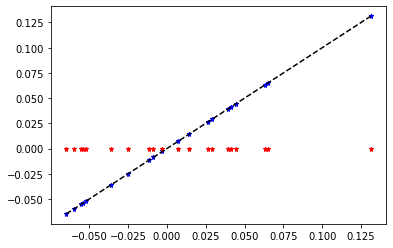

In [83]:
regularization = False

# h_coeff = 0.1
# H = h_coeff * np.diag(np.ones(n_s, ))

# HOp = H_Op(h=H)
# #HOp = HOp.toreal(forw=False, adj=True)

y_real = np.random.normal(0.0, 1.0, size=(n_v, ))
y_imag = np.random.normal(0.0, 1.0, size=(n_v, ))

HOp = None

# NOTE:
sigma = abs(
    np.random.normal(0.0, 1.0, size=(n_v, ))
)
weights = 1.0 / sigma**2.0

WOp = pylops.Diagonal(diag=weights, dtype="float64")

_x_for_MF = x_for_MF(
    Dop=Dop,
    f=f,
    d_real=y_real,
    d_imag=y_imag,
    WOp=WOp,
    HOp=HOp
)
_x_for_PF = x_for_PF(
    Dop=Dop,
    f=f,
    d_real=y_real,
    d_imag=y_imag,
    WOp=WOp,
    HOp=HOp
)


# NOTE: Plot
x_min = np.min(_x_for_MF)
x_max = np.max(_x_for_MF)

plt.figure()
plt.plot(_x_for_MF, _x_for_PF.real, linestyle="None", marker="*", markersize=5, color="b")
plt.plot(_x_for_MF, _x_for_PF.imag, linestyle="None", marker="*", markersize=5, color="r")

plt.plot(
    np.linspace(x_min, x_max, 10),
    np.linspace(x_min, x_max, 10),
    linestyle="--",
    color="black"
)

plt.show()

# Tests

## test 1

In [20]:
def calculate_f_tilde(f, Dop, shape):
    f_tilde = np.zeros(
        shape=shape, dtype="complex"
    )
    for i in range(f.shape[-1]):
        f_tilde[:, i] = Dop.forward_lop(x=f[:, i])
        
    return f_tilde
    

In [48]:
n_v = 100 # NOTE: n_v is the # of visibilities

# NOTE: Non-uniform points in the uv-space
u = np.random.uniform(-1.0, 1.0, n_v)
v = np.random.uniform(-1.0, 1.0, n_v)

uv = np.stack(
    arrays=(u, v), axis=-1
)

# NOTE: n_s is the # of source-plane pixels
n_s = 20

shape_2d = (20, 20)

# NOTE: n_p is the # of image-plane pixels
n_p = int(shape_2d[0] * shape_2d[1]) 

In [49]:
f = random_sparse_matrix(
    n_p=n_p, n_s=n_s
)

In [50]:
Dop = D_Op(
    uv=uv, shape_2d=shape_2d
)

In [57]:
# ------------------ #
# Matrix Formalism
# ------------------ #
f_tilde = calculate_f_tilde(
    f=f, Dop=Dop, shape=(n_v, n_s)
)

# ------------------ #
# Pylops Formalism
# ------------------ #
f_lops = pylops.MatrixMult(
    sparse.bsr_matrix(f), dtype='float64'
)

Op = Dop * f_lops

# NOTE: 
Op = Op.toreal(
    forw=False, adj=True
)

**forward**

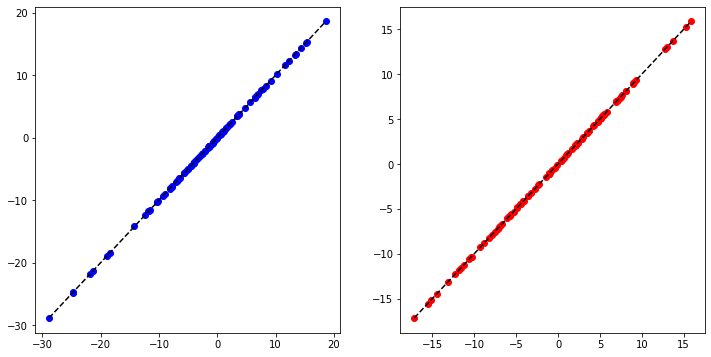

In [58]:
x = np.random.normal(0.0, 1.0, size=(n_s, ))

# ------------------ #
# Matrix Formalism
# ------------------ #
y_MF = f_tilde @ x

# ------------------ #
# Pylops Formalism
# ------------------ #
y_PF = Op @ x

# ------------------ #
# Visualization
# ------------------ #
figure, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6)
)
axes[0].plot(
    y_MF.real, y_PF.real, linestyle="None", marker="o", color="b"
)
axes[1].plot(
    y_MF.imag, y_PF.imag, linestyle="None", marker="o", color="r"
)

x_min_real = np.min([np.min(y_MF.real), np.min(y_PF.real)])
x_max_real = np.max([np.max(y_MF.real), np.max(y_PF.real)])

x_min_imag = np.min([np.min(y_MF.imag), np.min(y_PF.imag)])
x_max_imag = np.max([np.max(y_MF.imag), np.max(y_PF.imag)])

axes[0].plot(
    np.linspace(x_min_real, x_max_real, 10),
    np.linspace(x_min_real, x_max_real, 10),
    linestyle="--",
    color="black"
)
axes[1].plot(
    np.linspace(x_min_imag, x_max_imag, 10),
    np.linspace(x_min_imag, x_max_imag, 10),
    linestyle="--",
    color="black"
)

plt.show()

**adjoint**

**inverse**

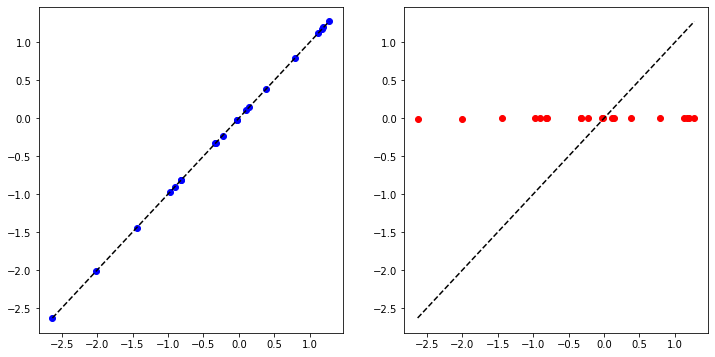

In [59]:
# ------------------ #
# Matrix Formalism
# ------------------ #
_x_MF = np.linalg.inv(f_tilde.real.T @ f_tilde.real + f_tilde.imag.T @ f_tilde.imag) @ (f_tilde.real.T @ y_MF.real + f_tilde.imag.T @ y_MF.imag)

# ------------------ #
# Pylops Formalism
# ------------------ #
_x_PF = Op.div(y_PF)

# ------------------ #
# Visualization
# ------------------ #
figure, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6)
)
axes[0].plot(
    x, _x_MF, linestyle="None", marker="o", color="b"
)
axes[1].plot(
    x, _x_PF, linestyle="None", marker="o", color="r"
)

x_min_MF = np.min([np.min(x), np.min(_x_MF)])
x_max_MF = np.max([np.max(x), np.max(_x_MF)])
x_min_PF = np.min([np.min(x), np.min(_x_PF)])
x_max_PF = np.max([np.max(x), np.max(_x_PF)])

axes[0].plot(
    np.linspace(x_min_MF, x_max_MF, 10),
    np.linspace(x_min_MF, x_max_MF, 10),
    linestyle="--",
    color="black"
)
axes[1].plot(
    np.linspace(x_min_PF, x_max_PF, 10),
    np.linspace(x_min_PF, x_max_PF, 10),
    linestyle="--",
    color="black"
)

plt.show()

In [82]:
x_MF_adj = f_tilde.T @ y_MF

x_MF_adj_real = f_tilde.real.T @ y_MF.real
x_MF_adj_imag = f_tilde.imag.T @ y_MF.imag

# NOTE: The 2 do noot agree as there are cross terms ...
print(x_MF_adj)
print(x_MF_adj_real)
print(x_MF_adj_imag)


# x_PF_adj = Op.H @ y_PF

# print(x_MF_adj)
# print(x_PF_adj)

# # NOTE: ...
# figure, axes = plt.subplots(
#     nrows=1, ncols=2, figsize=(12, 6)
# )
# axes[0].plot(
#     y_MF.real, y_MF.imag, linestyle="None", marker="o", color="b"
# )
# axes[1].plot(
#     y_PF.real, y_PF.imag, linestyle="None", marker="o", color="r"
# )
# plt.show()

[ -351.76593572-251.39820824j  -407.6346851  -74.89600309j
  -603.99511631-120.5576404j   -692.83028757 +38.29413535j
  -609.516541  -157.08134212j  -178.06283137+198.86363311j
   196.2445891  +17.78053595j  -262.38230792-181.66972807j
  -948.01619645-149.44508803j  -311.56492966 -45.86774614j
  -374.9243447 -145.58021955j  -474.87023646-121.09461846j
  -510.17941491+166.72840194j  -361.71921492 -87.21653439j
  -296.66695776 +59.21618486j -1310.42274943-145.30237015j
  -773.73746271 +44.1728771j   -121.68073708 +26.85836056j
  -252.8873167 -196.3400142j    -14.21556133 -82.56648484j]
[ -192.28538047  -551.3152297  -1127.75282102  -152.19969086
  -578.3643445   -588.01373814  -157.87467243 -1348.22800465
  -668.03280663  -371.23814694  -428.04781119  -338.43475524
  -527.26533896  -108.82317681  -378.70416061 -1198.42187189
  -770.05916459   -60.6986336   -765.61461476   127.72623357]
[  159.48055525  -143.6805446   -523.75770471   540.63059671
    31.1521965   -409.95090677  -354.11926

## test 2

In [77]:
n = 10

x = np.random.normal(0.0, 1.0, size=(n, ))
A = np.random.normal(0.0, 1.0, size=(n, n))

# y = Ax
y = np.dot(A, x)

# NOTE: ...
x_adj = np.dot(A.T, y)

_x = np.linalg.solve(A, y)

print(x)
print(x_adj)
print(_x)

print("------")

AOp = pylops.MatrixMult(
    sparse.bsr_matrix(A), dtype='float64'
)

y = AOp @ x

x_adj = AOp.H * y

_x = AOp.div(y)

print(x)
print(x_adj)
print(_x)

[-0.7437325  -0.08018382 -0.88577307 -1.94660713  0.72925361 -0.06314401
  0.82390237  0.36044834  0.25380138 -0.27730707]
[ -4.96568334  -8.52946803  -7.08114653  -7.85687064   0.92324827
  11.51695903  13.38629372   8.40620139  13.3376979  -13.5179274 ]
[-0.7437325  -0.08018382 -0.88577307 -1.94660713  0.72925361 -0.06314401
  0.82390237  0.36044834  0.25380138 -0.27730707]
------
[-0.7437325  -0.08018382 -0.88577307 -1.94660713  0.72925361 -0.06314401
  0.82390237  0.36044834  0.25380138 -0.27730707]
[ -4.96568334  -8.52946803  -7.08114653  -7.85687064   0.92324827
  11.51695903  13.38629372   8.40620139  13.3376979  -13.5179274 ]
[-0.7437325  -0.08018382 -0.88577307 -1.94660713  0.72925361 -0.06314401
  0.82390237  0.36044834  0.25380138 -0.27730707]
